# Beamline 8.3.2 Reconstruction

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import sys
import os
import multiprocessing as mp
os.environ['NUMEXPR_MAX_THREADS'] = str(mp.cpu_count()) # to avoid numexpr warning
import time
import numexpr
import numpy as np
from skimage import transform, filters, io
import tomopy
import svmbir
import dxchange
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, fixed, FloatSlider, IntSlider
import ALS_recon_helper as als
import util
import copy
import pandas as pd
import base64
import pickle

from pathlib import Path


use_gpu = als.check_for_gpu()
layout = widgets.Layout(width='auto', height='40px')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Choose Data

In [8]:
dataDir = "/global/cfs/cdirs/als/users/tomography_notebooks/example_data" # where is the raw data
basepath = Path(dataDir)
filelist, names = als.get_directory_filelist(dataDir)
file_choice = als.make_file_selector(filelist, names, dataDir)
widgets.Box([widgets.Label(value='Make a File Selection'), file_choice])
display(file_choice)

interactive(children=(Select(description='files', layout=Layout(width='max-content'), options=('14: 20191016_0…

### Find Center of Rotation (COR)
##### Check COR by manually aligning 0 and 180 degree projections
###### not doing anything with y shift at the moment

Output()

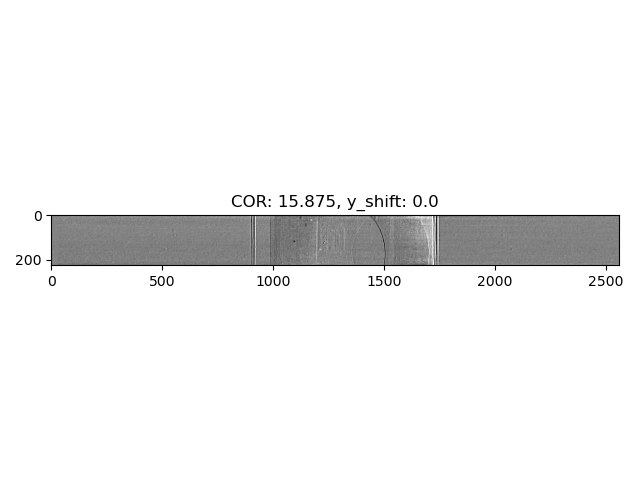

In [9]:
metadata = als.read_metadata(file_choice.result[0], print_flag = False)
tomo, _ = als.read_data(file_choice.result[0], proj=slice(0,None,metadata['numangles']-1), downsample_factor=None)
cor_init = als.auto_find_cor(file_choice.result[0])
first_proj, last_proj_flipped = tomo[0], np.fliplr(tomo[-1])

axs, img, proj180_shift_sliders, proj180_shift_output = als.plot_0_and_180_proj_diff(first_proj,last_proj_flipped,init_cor=-2*cor_init,fignum=1)
display(proj180_shift_sliders,proj180_shift_output)

##### Reconstruct with range of CORs to fine tune. With mismatched COR, arc/shadow artifacts appear in image. Adjust COR to minimize artifacts

In [10]:
all_parameter_widgets = util.get_options(file_choice)
widgets.VBox(all_parameter_widgets)

In [11]:
settings = {
    "path": file_choice.result[0], 
    "name": os.path.split(os.path.splitext(file_choice.result[0])[0])[-1],
    "angles_ind": all_parameter_widgets[1].result, 
    "slices_ind": all_parameter_widgets[2].result,
    "downsample_factor": all_parameter_widgets[3].result,
    "COR": -proj180_shift_sliders.children[0].value/2,
    "cor_search_range": all_parameter_widgets[4].result, 
    "cor_search_step": all_parameter_widgets[5].result, 
    "fc": all_parameter_widgets[6].result, 
    "use_gpu": use_gpu
}

interactive(children=(IntSlider(value=20, description='COR', layout=Layout(width='50%'), max=39, readout=False…

interactive(children=(FloatRangeSlider(value=(-0.0003180603528744541, 0.0036192141566425565), description='Col…

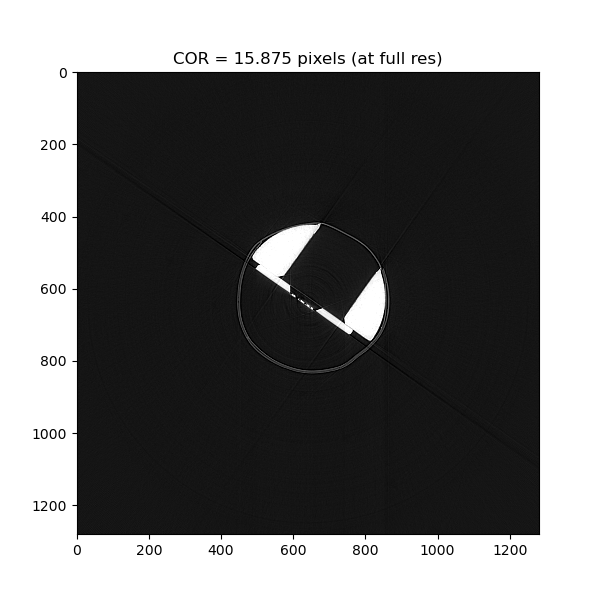

In [12]:
recons, cors = als.cor_search_reconstructions(**settings)
img, axs, clim_slider = als.plot_recon(recons[0],fignum=1,figsize=6)

cor_slider = widgets.interactive(als.set_cor, i=IntSlider(description='COR', layout=widgets.Layout(width='50%'),
                                                          min=0, max=len(cors)-1, step=1, value=len(cors)//2, readout=False),
                                 img=fixed(img), axs=fixed(axs), recons=fixed(recons), cors=fixed(cors))
display(cor_slider)
display(clim_slider)

### Select proprocessing parameters (mostly stripe removal)
##### Remove artifacts with additional sinogram preprocessing and compare to original. FYI, strong stripe removal takes time, can reduce resolution and sometimes even introduce artifacts too, so only use as much as you need to remove significant artifacts
##### Note: At full resolution (1313 ang x 2560 rays), reconstruction takes ~2-4 sec/slice with GPU, ~30 sec/slice on CPU. Downsampling by 2x reduces time by ~4x (plus loading time)


interactive(children=(FloatRangeSlider(value=(-0.000355288632272277, 0.0036465559015050534), description='Colo…

CPU times: user 14.1 s, sys: 11 s, total: 25.1 s
Wall time: 11.3 s


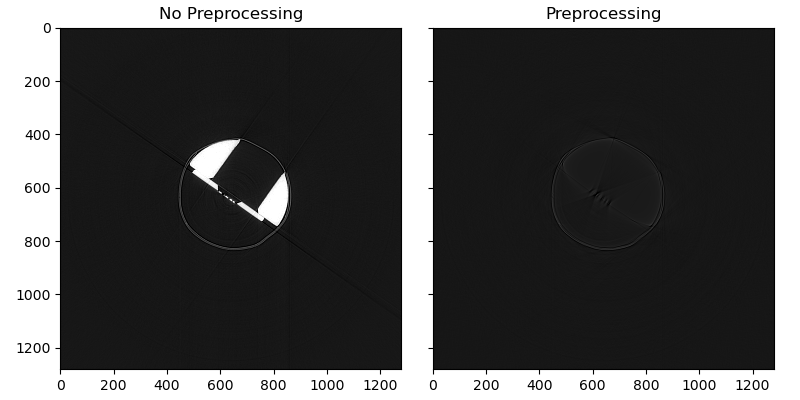

In [13]:
%%time
"""
########## PARAMETERS ##########

### COR ###
Center of rotation. Set to best value found above

### Minimum_transmission ###
Threshold for pre-log, normalized sinogram.
A higher value can reduce streaking artifacts between bright features, but also biases image down (ie darker).
Set to None or 0 to turn off

### sm_size ###
Window size of the median filter to remove small stripes. Larger is stronger but takes longer.
Set to appx width of small stripes. Always choose odd value, set to 1 to turn off.

### la_size ###
Window size of the median filter to remove large stripes.
Set to appx width of large stripes -- should be larger value than sm_size. Always choose odd value, set to 1 to turn off.

### snr ###
# Sensitivity of large stripe detection method. Smaller is more sensitive. No affect on small stripes. Recommended values: 1.1 -- 3.0.

"""
minimum_transmission= 0.95
sm_size = 11
la_size = 1
snr = 3

preprocess_settings = {
    "minimum_transmission": minimum_transmission,
    "snr": snr, 
    "la_size": la_size,
    "sm_size": sm_size,
}

settings["COR"] = cors[cor_slider.children[0].value]/settings['downsample_factor'] # auto-select from above cell

tomo, angles = als.read_data(settings["path"],
                             proj=settings['angles_ind'],
                             sino=settings["slices_ind"],
                             downsample_factor=settings["downsample_factor"])
recon = als.astra_fbp_recon(tomo, angles, **settings)

tomo, angles = als.read_data(settings["path"],
                             preprocess_settings=preprocess_settings,
                             proj=settings['angles_ind'],
                             sino=settings["slices_ind"],
                             downsample_factor=settings["downsample_factor"])
preprocess_recon = als.astra_fbp_recon(tomo, angles, **settings)

img, axs, clim_slider = als.plot_recon_comparison(recon, preprocess_recon, titles=['No Preprocessing','Preprocessing'], fignum=4, figsize=4)
display(clim_slider)


### Optional: SVMBIR reconstruction (for better image quality)
##### Note: SVMBIR is MUCH slower.
##### At full resolution (1313 ang x 2560 rays), takes ~2-4 min/slice with all 128 exclusive node threads (uses CPU only). Downsampling by 2x reduces time by ~4x (plus loading time)

In [ ]:
%%time
"""
########## PARAMETERS ##########

# Default settings are typically good, don't necessarily need to change

### p ###
smoothing parameter for large grayscale differences (ie contrasting pixels). Between 1 and 2 (1 = total variation regularization, 2 = Tikhonov regularization)

### q ###
# smoothing parameter for small grayscale differences (ie. similar pixels). Between p and 2

### T ###
# transition value from q to p (in pixel grayscale difference). Must be > 0

### sharpness ###
# stregth of smoothing -- lower is more smooth. +1 change is equivalent to +6 dB snr. Can typically just change one or the other

### snr_dB ###
# strength of smoothing -- lower is more smooth. +6 dB is equivalent to +1 sharpness. Can typically just change one or the other
"""
p = 1.2 
q = 2 
T = 0.1 
sharpness = 0 
snr_dB = 40.0 
########## dont touch code below ##########

svmbir_settings = {
    "p": p, 
    "q": q, 
    "T": T,
    "sharpness": sharpness, 
    "snr_dB": snr_dB,
    "max_iter": 100,
    "COR": process_settings['COR']/process_settings['downsample_factor'],
    "init_image": preprocess_recon
}

tomo, angles = als.read_data(settings["path"], sino=settings["slices_ind"], downsample_factor=settings["downsample_factor"],args=process_settings)
svmbir_recon = als.svmbir_recon(tomo,angles,**svmbir_settings)
print(f"Finisehd reconstruction, size: {fbp_recon.shape}")
print('')
print('This took:')

In [ ]:
img, axs, clim_slider = als.plot_recon_comparison(preprocess_recon, svmbir_recon, titles=['FBP','SVMBIR'], fignum=5, figsize=4)
display(clim_slider)

### Reconstruct 3D volume
##### At full resolution (1313 ang x 2560 rays), 100 slices takes ~ 30-60 sec with 1 GPU
##### IF YOU LIKED PREPROCESSING RESULTS: be sure to add relevent lines below
##### For viewing

In [ ]:
%%time
########## parameters (assumes others have ben set above) ##########
slices_ind = slice(500,600,1)
settings["slices_ind"] = slices_ind
# ########## dont touch code below ##########
tomo, angles = als.read_data(settings["path"],preprocess_settings=preprocess_settings,
                            proj=settings['angles_ind'],sino=settings["slices_ind"],downsample_factor=settings["downsample_factor"])
print(f"Projection data shape: {tomo.shape}")
# recon = als.astra_fbp_recon(tomo,angles,**settings)
print(f"Finished reconstruction, size: {recon.shape}")
img, axs, clim_slider = als.plot_recon(recon,fignum=6,figsize=6,clims=[np.percentile(recon[0],1),np.percentile(recon[0],99)])
slice_slider = widgets.interactive(als.set_slice, slice_num=IntSlider(min=0, max=len(recon)-1, step=1, value=len(recon)//2),
                                   img=fixed(img), axs=fixed(axs), recon=fixed(recon), slices=fixed(np.arange(slices_ind.start,slices_ind.stop)))
display(slice_slider)
display(clim_slider)
print('')
print('This took:')

##### For saving

In [ ]:
########## parameters (assumes others have ben set above) ##########
outputDir = als.get_scratch_path() + "/tomo_data/" # somewhere you can write lots of data
subdirectoryname = 'spiderman' # new folder where reconstuctions will be saved
start = 0
stop = 20
nchunk = 10
########## dont touch code below ##########
saveDir = os.path.join(outputDir,subdirectoryname,settings["name"])
if not os.path.exists(saveDir): os.makedirs(saveDir)
saveName = os.path.join(saveDir,"img")
for i in range(np.ceil((stop-start)/nchunk).astype(int)):
    start_iter = start+i*nchunk
    stop_iter = np.minimum((i+1)*nchunk,stop)
    tomo, angles = als.read_data(settings["path"],preprocess_settings=preprocess_settings,
                            proj=settings['angles_ind'],sino=slice(start_iter,stop_iter,1),downsample_factor=settings["downsample_factor"])
    print(f"Starting recon of slices {start_iter}-{stop_iter}...",end=' ')
    tic = time.time()
    recon = als.astra_fbp_recon(tomo,angles,**settings)
    print(f"Finished: took {time.time()-tic} sec. Saving files...")
    dxchange.write_tiff_stack(recon, fname=saveName, start=start_iter)

### Submit

Once you have deicded on a dictionary of settings and preprocess settings that you want to use for all of your files, run the following cells. You can confirm that the settings have been adjusted correctly as well. If there are any errors, please scroll up and adjust them using the dropdown/selectors above.

In [20]:
l = []
for file in filelist:
    out = als.make_settings_dict(file, basepath, settings)
    l.append(out)
    
als.view_dictionaries(l)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
path,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...,/global/cfs/cdirs/als/users/tomography_noteboo...
name,20180309_162630_fly_z30mm_20keV_3p3umPix.h5,20180327_101612_harding_feather.h5,20180327_103143_harding_adapter-009.h5,20180327_112404_harding_hair-016.h5,20180327_114740_harding_flytrap_x00y01.h5,20180426_110223_alka_seltzer1_x00y01-021.h5,20180426_125539_feather1_x00y01-006.h5,20190501_120317_projectCocoon.h5,20190501_122704_spiderman_try3.h5,20190501_130044_fennel.h5,20190501_163050_barred_filefish_tooth.h5,20190501_170503_dinosaur_tendon_and_magnetic_p...,20190524_085542_clay_testZMQ.h5,20190627_142116_bread_crust.h5,20191016_095526_test_after_power_outage.h5
angles_ind,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
slices_ind,"slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)","slice(112, 113, 1)"
downsample_factor,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
COR,7.9375,7.9375,7.9375,7.9375,7.9375,7.9375,7.9375,7.9375,7.9375,7.9375,7.9375,7.9375,7.9375,7.9375,7.9375
cor_search_range,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
cor_search_step,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
fc,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
use_gpu,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


The next cell will prepare the config files for you. These are each a slurm job script that can be submitted through terminal. A helper bash script that can submit them all in a loop is also provided.

In [36]:
with open ("template_job.txt", "r") as t:
    temp = t.read()
    
saveDir = "configs/"
configsDir = basepath/saveDir
configsDir = Path("configs/")
if configsDir.exists():
    pass
else:
    os.mkdir(configsDir)

all_dictionaries = []
for i, d in enumerate(l):
    out = als.make_dict_with_settings_and_preprocess(d, preprocess_settings)
    enc = als.dictionary_prep(out)
    all_dictionaries.append(enc)
    with open(os.path.join(configsDir,"config"+str(i)+".sh"), 'w') as f:
        script = temp + " " + enc
        f.write(script)
        f.close()



In [34]:
#Please use this to change out the filepath in the 
#bash script (the helper script to loop and submit all configs).
print(str(configsDir.absolute())+"/*")

/pscratch/sd/l/lgupta/als_microct-recon/configs/*
